# Import Libraries

In [413]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder , StandardScaler
from sklearn.metrics import accuracy_score,classification_report,roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import shap

# load datasets

In [414]:
df = pd.read_csv('/content/WA_Fn-UseC_-HR-Employee-Attrition.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


# basic EDA

In [415]:
df.shape

(1470, 35)

In [416]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [417]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


attritution distribution

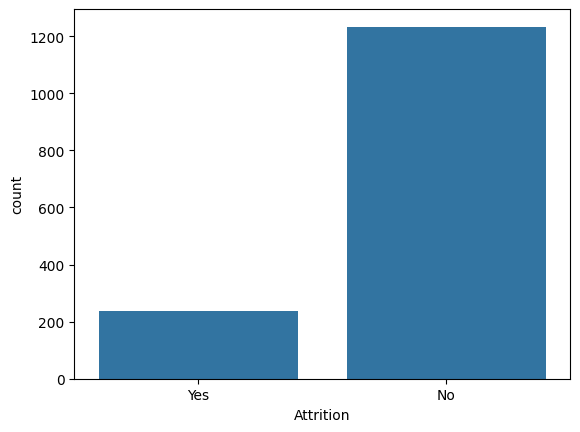

In [418]:
sns.countplot(x='Attrition', data=df)
plt.show()

# drop irrelevant column

In [419]:
df = df.drop(['EmployeeNumber','Over18','StandardHours','EmployeeCount'],axis=1)

# feature engineering

In [420]:
df['Income_Per_Year'] = df['MonthlyIncome'] * 12
df['Experience_Ratio'] = df['TotalWorkingYears'] / (df['Age'] + 1)
df['Promotion_Gap'] = df['YearsAtCompany'] - df['YearsSinceLastPromotion']

In [421]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Income_Per_Year,Experience_Ratio,Promotion_Gap
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,0,8,0,1,6,4,0,5,71916,0.190476,6
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,1,10,3,3,10,7,1,7,61560,0.200000,9
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Yes,15,3,2,0,7,3,3,0,0,0,0,25080,0.184211,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Yes,11,3,3,0,8,3,3,8,7,3,0,34908,0.235294,5
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,1,6,3,3,2,2,2,2,41616,0.214286,0


# Train - Test Split

In [422]:
x = df.drop('Attrition',axis=1)
y = df['Attrition']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

# encode target variables

In [423]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# encode categorical features & feature scaling

In [426]:
cat_cols = x_train.select_dtypes(include='object').columns.tolist()
num_cols = x_train.select_dtypes(exclude='object').columns.tolist()

In [428]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ]
,remainder='passthrough')


preprocessor.fit(x_train)
x_train = preprocessor.transform(x_train)
x_test = preprocessor.transform(x_test)


# logistic regression model

In [429]:
lr = LogisticRegression(max_iter=1000)
lr.fit(x_train, y_train)

y_pred_lr = lr.predict(x_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.891156462585034
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       255
           1       0.63      0.44      0.52        39

    accuracy                           0.89       294
   macro avg       0.77      0.70      0.73       294
weighted avg       0.88      0.89      0.88       294



# random forest model

In [430]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

rf.fit(x_train, y_train)

y_pred_rf = rf.predict(x_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.8809523809523809
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       255
           1       1.00      0.10      0.19        39

    accuracy                           0.88       294
   macro avg       0.94      0.55      0.56       294
weighted avg       0.90      0.88      0.84       294



# ROC-AUC Score

In [431]:
y_prob_rf = rf.predict_proba(x_test)[:,1]
roc_auc = roc_auc_score(y_test, y_prob_rf)

print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.74228255404726


# Feature Importance(Random Forest)

In [439]:
X = preprocessor.get_feature_names_out()
feature_importance = pd.DataFrame({
    'Feature': X,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance.head(10)

,Feature,Importance
46,cat__OverTime_Yes,0.061286
23,num__Income_Per_Year,0.060545
9,num__MonthlyIncome,0.060518
24,num__Experience_Ratio,0.057038
0,num__Age,0.047015
1,num__DailyRate,0.044031
10,num__MonthlyRate,0.039630
5,num__HourlyRate,0.038078
16,num__TotalWorkingYears,0.036242
2,num__DistanceFromHome,0.036210


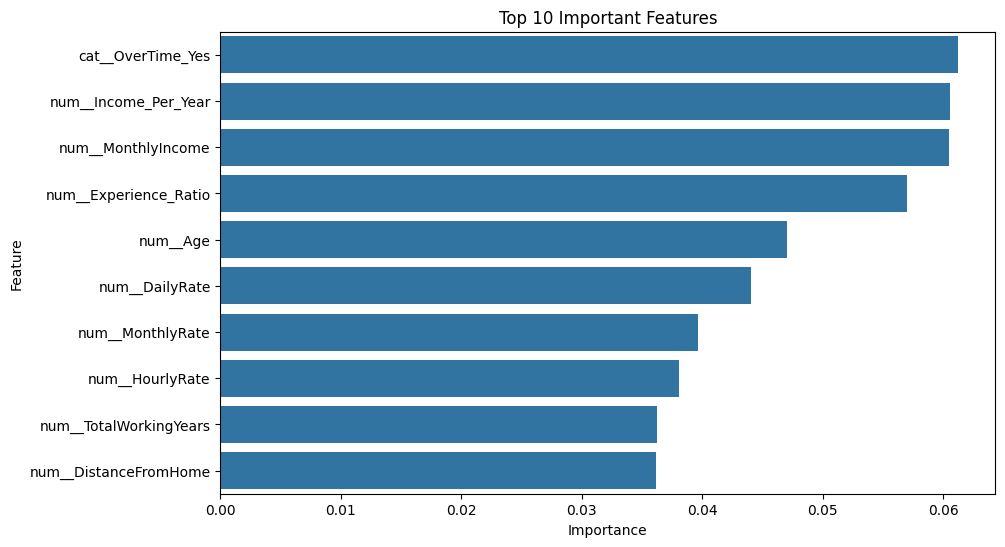

In [436]:
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title("Top 10 Important Features")
plt.show()

# SHAP Explainability (BEST PART)

In [437]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(x_train)

Global Explaination

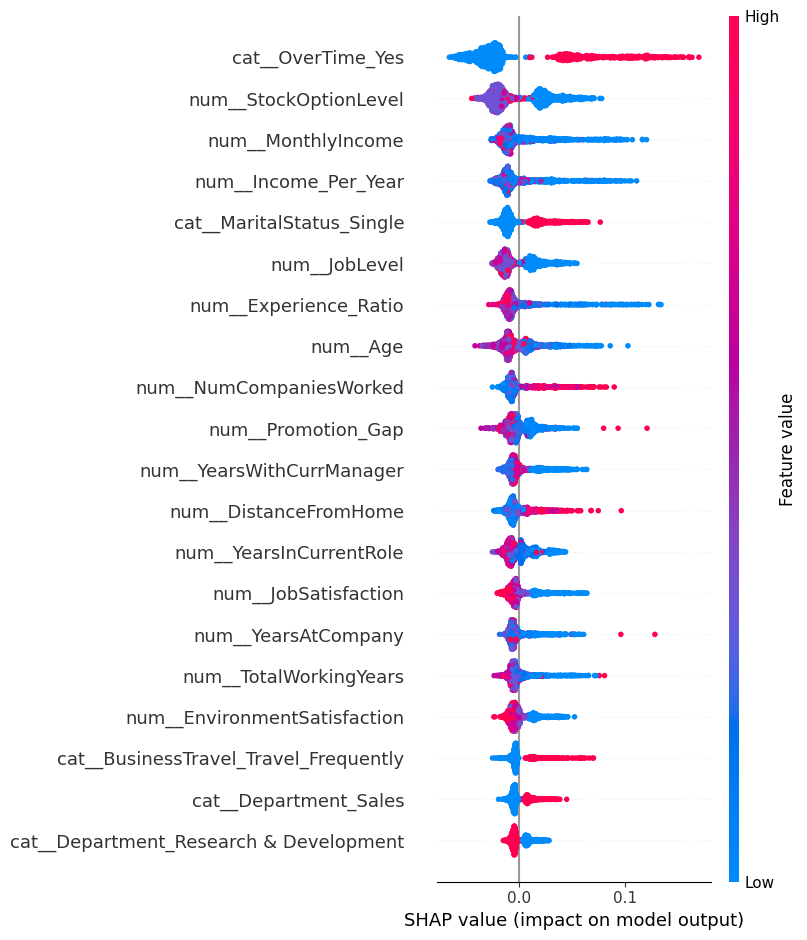

In [441]:
shap.summary_plot(shap_values[:, :, 1], x_train, feature_names=X)

individual employee explaination

In [443]:
shap.force_plot(
    explainer.expected_value[1],
    shap_values[0, :, 1], # SHAP values for the first sample (index 0), positive class (index 1)
    x_train[0],          # Original feature values for the first sample
    feature_names=X
)

# prediction

In [457]:
sample_input = {
    "Age": 35,
    "BusinessTravel": "Travel_Rarely",
    "DailyRate": 1100,
    "Department": "Research & Development",
    "DistanceFromHome": 10,
    "Education": 3,
    "EducationField": "Life Sciences",
    "EnvironmentSatisfaction": 3,
    "Gender": "Male",
    "HourlyRate": 65,
    "JobInvolvement": 3,
    "JobLevel": 2,
    "JobRole": "Research Scientist",
    "JobSatisfaction": 2,
    "MaritalStatus": "Single",
    "MonthlyIncome": 6000,
    "MonthlyRate": 18000,
    "NumCompaniesWorked": 1,
    "OverTime": "Yes",
    "PercentSalaryHike": 12,
    "PerformanceRating": 3,
    "RelationshipSatisfaction": 3,
    "StockOptionLevel": 1,
    "TotalWorkingYears": 8,
    "TrainingTimesLastYear": 3,
    "WorkLifeBalance": 2,
    "YearsAtCompany": 4,
    "YearsInCurrentRole": 2,
    "YearsSinceLastPromotion": 3,
    "YearsWithCurrManager": 3
}

In [458]:
input_df = pd.DataFrame([sample_input])
input_df

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,35,Travel_Rarely,1100,Research & Development,10,3,Life Sciences,3,Male,65,3,2,Research Scientist,2,Single,6000,18000,1,Yes,12,3,3,1,8,3,2,4,2,3,3


In [459]:
input_df['Income_Per_Year'] = input_df['MonthlyIncome'] * 12
input_df['Promotion_Gap'] = input_df['YearsAtCompany'] - input_df['YearsSinceLastPromotion']
input_df['Experience_Ratio'] = input_df['TotalWorkingYears'] / (input_df['Age'] + 1)

In [460]:
input_processed = preprocessor.transform(input_df)

# make prediction

In [461]:
prediction = rf.predict(input_processed)[0]
probability = rf.predict_proba(input_processed)[0][1]

print("Attrition Prediction:", "Yes" if prediction == 1 else "No")
print("Attrition Probability:", round(probability, 3))

Attrition Prediction: No
Attrition Probability: 0.108
